# Time Series Analysis with LightGBM

In [22]:
# !pip install ucimlrepo --quiet
import pandas as pd
import numpy as np
import ucimlrepo
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from datetime import datetime, timedelta

In [2]:
import os
data_path = os.environ.get('DATA_PATH', 'data')

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
appliances_energy_prediction = fetch_ucirepo(id=374) 
  
# data (as pandas dataframes) 
X = appliances_energy_prediction.data.features 
y = appliances_energy_prediction.data.targets

In [4]:
# To Pandas DataFrame
df = pd.concat([X, y], axis=1)

# Add space between date and time
df['date'] = df['date'].apply(lambda x: x[:10] + ' ' + x[11:])
# Cast to datetime
df['date'] = pd.to_datetime(df['date'])

# Set index
df.set_index('date', inplace=True)

df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 07:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
2016-01-11 07:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2016-01-11 07:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
2016-01-11 07:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390,50
2016-01-11 07:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [5]:
# Resample to hour
df = df.resample('h').sum()
df.index.freq = 'h'

In [6]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    # Null Hypothesis: Data has unit root. Non-Stationary.
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


adf_test(df['Appliances'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.838231e+00
p-value                 1.696088e-14
# lags used             2.700000e+01
# observations          3.270000e+03
critical value (1%)    -3.432351e+00
critical value (5%)    -2.862424e+00
critical value (10%)   -2.567241e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [6]:
class TSA:
  def __init__(self):
    pass


  def load_data(self, file_path):
    """Loads data from a CSV file and returns a Pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, index_col='Date', parse_dates=['Date'])
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None


  # Preprocess the data and engineer features
  def preprocess_data(self, df):
    """Preprocesses the data and engineers time-based features."""
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Hour'] = df.index.hour


    # Lagged features (example: sales from previous 24 hours)
    for i in range(1, 24):
      df[f'ConsumptionLag_{i}'] = df['Appliances'].shift(i)

    # Drop rows with NaN values after lagging
    df = df.dropna()

    return df


  # Split the data into training and testing sets
  def split_data(self, df, test_size=0.2):
      """Splits the data into training and testing sets."""
      X = df.drop('Appliances', axis=1)
      y = df['Appliances']
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
      return X_train, X_test, y_train, y_test


  # Train the LightGBM model
  def train_model(self, X_train, y_train):
      """Trains a LightGBM model on the training data."""
      lgb_train = lgb.Dataset(X_train, y_train)
      lgb_eval = lgb.Dataset(X_train, y_train, reference=lgb_train)
      params = {
          'objective': 'regression',
          'metric': 'mape',
          'boosting_type': 'gbdt',
          'learning_rate': 0.05,
          'num_leaves': 15,
          'max_depth': 15,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'verbose': -1,
      }
      gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(stopping_rounds=10)])
      return gbm


  def preprocess_forecast(self, df):
    """Preprocesses the data and engineers time-based features."""

    # Drop columns that we don't have at the time of the forecast
    # Keep what we will have at the prediction time.
    cols = ['Appliances', 'DayOfWeek', 'Month', 'Quarter', 'Year',
       'DayOfYear', 'WeekOfYear', 'ConsumptionLag_1',
       'ConsumptionLag_2', 'ConsumptionLag_3', 'ConsumptionLag_4',
       'ConsumptionLag_5', 'ConsumptionLag_6', 'ConsumptionLag_7',
       'ConsumptionLag_8', 'ConsumptionLag_9', 'ConsumptionLag_10',
       'ConsumptionLag_11', 'ConsumptionLag_12', 'ConsumptionLag_13',
       'ConsumptionLag_14', 'ConsumptionLag_15', 'ConsumptionLag_16',
       'ConsumptionLag_17', 'ConsumptionLag_18', 'ConsumptionLag_19',
       'ConsumptionLag_20', 'ConsumptionLag_21', 'ConsumptionLag_22',
       'ConsumptionLag_23', 'Hour']

    df = df[cols]

    return df



  # Predict
  def model_predict(self, model, X):
      """Evaluates the model on the test data."""
      y_pred = model.predict(X, num_iteration=model.best_iteration)
      return y_pred


  # Evaluate the model
  def evaluate_model(self, model, X_test, y_test):
      """Evaluates the model on the test data."""
      y_pred = model.predict(X_test, num_iteration=model.best_iteration)
      mape = mean_absolute_percentage_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      print(f'MAE: {mae}')
      print(f'MAPE: {mape}')
      return y_pred


  # Visualize the predictions
  def visualize_predictions(self, y_test, y_pred):
      """Visualizes the predictions against the actual values."""
      plt.figure(figsize=(19, 6))
      plt.plot(y_test.index, y_test.values, label='Actual', color='darkgray', linewidth=3)
      plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.5, linestyle='--',color='green')
      plt.xlabel('Date')
      plt.ylabel('Consumption')
      plt.title('Consumption Prediction')
      plt.legend()
      plt.grid(True)
      plt.show()

In [7]:
# Instantiate
tsa = TSA()

In [8]:
# Preprocess Data
prep = tsa.preprocess_data(df)

In [9]:
# Split Data
X_train, X_test, y_train, y_test = tsa.split_data(prep)

In [10]:
# Train Model
model = tsa.train_model(X_train, y_train)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's mape: 2.27


In [11]:
# Evaluate Model
y_pred = tsa.evaluate_model(model, X_test, y_test)

MAE: 190.81599575101984
MAPE: 6.580186801118907e+16


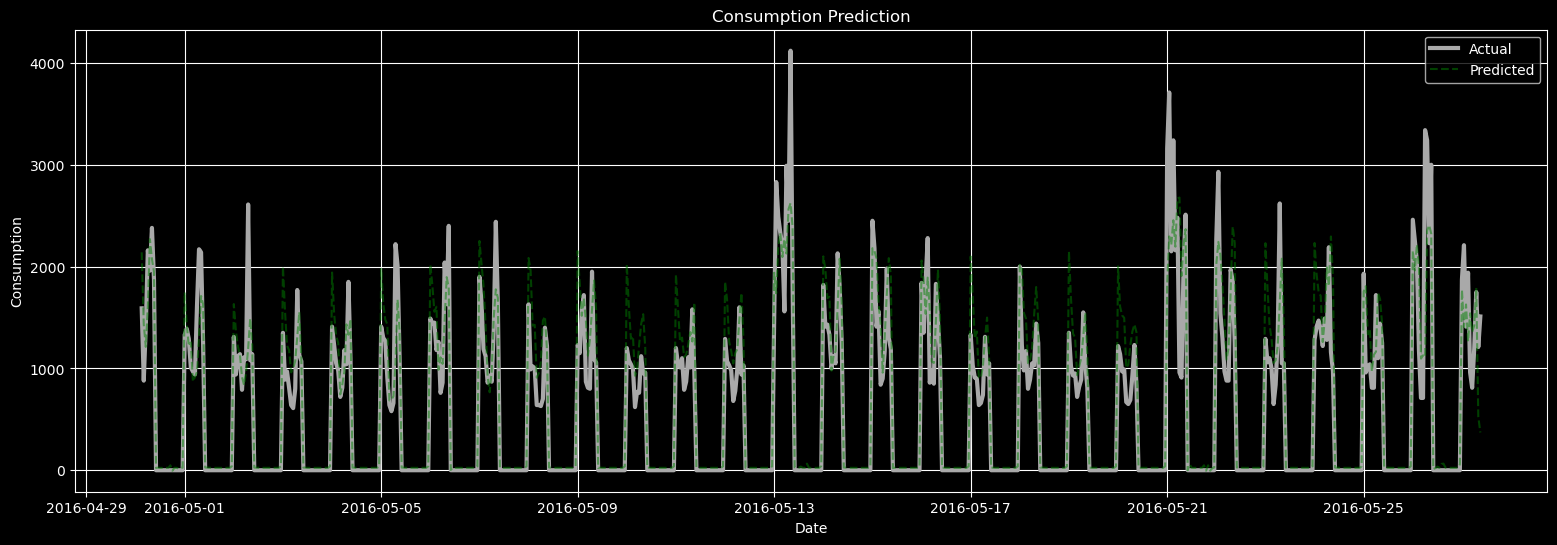

In [12]:
# Visualize
tsa.visualize_predictions(y_test, y_pred)

In [13]:
# Eval dataframe
df_eval= pd.DataFrame({
    'Actual': y_test,
    'Pred': y_pred.astype(int),
    'diff': y_test - y_pred.astype(int),
    'mape(int%)': np.round(100*abs(y_test - y_pred)/y_test,2)
})

# Clean zeroes: Everytime we see a "actual == 0", the division by 0 gives us error.
# This is just a small adjustment to help calculations
df_eval['mape(int%)'] = np.select(condlist=[(df_eval['Actual'] == 0) & (df_eval['Pred'] == 0),
                                      (df_eval['Actual'] == 0) & (df_eval['Pred']!= 0)],
                            choicelist= [0,100], default=df_eval['mape(int%)'])
df_eval

,Actual,Pred,diff,mape(int%)
date,,,,
2016-04-30 03:00:00,1590,2140,-550,34.60
2016-04-30 04:00:00,880,1432,-552,62.74
2016-04-30 05:00:00,1420,1211,209,14.68
2016-04-30 06:00:00,2160,1611,549,25.41
2016-04-30 07:00:00,1960,2269,-309,15.81
...,...,...,...,...
2016-05-27 05:00:00,810,1356,-546,67.46
2016-05-27 06:00:00,1190,1420,-230,19.35
2016-05-27 07:00:00,1750,1790,-40,2.29


In [14]:
df_eval.mean()

Actual        572.839695
Pred          665.552672
diff          -92.712977
mape(int%)     71.947679
dtype: float64

In [19]:
def future_dates(df):
  '''
  Create the next step in the future for forecast prediction.
  '''

  # Predict into the future using the model
  future_dates = pd.date_range(start=df.index[-1] + timedelta(hours=1), periods=1, freq='h')
  future_df = pd.DataFrame(index=future_dates, columns=prep_forecast.columns)

  # Add columns
  future_df['DayOfWeek'] = future_df.index.dayofweek
  future_df['Month'] = future_df.index.month
  future_df['Quarter'] = future_df.index.quarter
  future_df['Year'] = future_df.index.year
  future_df['DayOfYear'] = future_df.index.dayofyear
  future_df['WeekOfYear'] = future_df.index.isocalendar().week
  future_df['Hour'] = future_df.index.hour

  lags = ['ConsumptionLag_1', 'ConsumptionLag_2', 'ConsumptionLag_3', 'ConsumptionLag_4',
          'ConsumptionLag_5', 'ConsumptionLag_6', 'ConsumptionLag_7', 'ConsumptionLag_8', 'ConsumptionLag_9',
          'ConsumptionLag_10', 'ConsumptionLag_11', 'ConsumptionLag_12', 'ConsumptionLag_13', 'ConsumptionLag_14',
          'ConsumptionLag_15', 'ConsumptionLag_16','ConsumptionLag_17', 'ConsumptionLag_18', 'ConsumptionLag_19',
        'ConsumptionLag_20', 'ConsumptionLag_21', 'ConsumptionLag_22', 'ConsumptionLag_23']

  # Lagged features (from previous 24 hours)
  latest24h = df['Appliances'].tail(25).values[::-1]

  for n,c in enumerate(future_df[lags].columns):
    future_df[c] = latest24h[n]

  return future_df

In [20]:
# Preprocessed Data for Forecast
prep_forecast = tsa.preprocess_forecast(prep)

# Retrain model with less features
model2 = tsa.train_model(prep_forecast.drop('Appliances', axis=1),
                         prep_forecast['Appliances'])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's mape: 4.44614


In [23]:
# Estimating for 48 hours ahead.

for fcast in range(48):
  # Create one future hour observation
  future_df = future_dates(prep_forecast)

  # Predict
  prediction = tsa.model_predict(model2, future_df.drop('Appliances', axis=1))
  print(f'The prediction for the next hour is {prediction[0]}')

  # Add the prediction to the data
  future_df['Appliances'] = prediction[0].astype(int)
  future_df

  # Append to the preprocessed dataset
  prep_forecast = pd.concat([prep_forecast, future_df])

The prediction for the next hour is 66.19362538347704
The prediction for the next hour is 39.18000191736715
The prediction for the next hour is 41.53253953736249
The prediction for the next hour is 41.709636135562235
The prediction for the next hour is 41.37869303489598
The prediction for the next hour is 41.37869303489598
The prediction for the next hour is 41.37869303489598
The prediction for the next hour is 41.37869303489598
The prediction for the next hour is 41.677529103913976
The prediction for the next hour is 41.37869303489598
The prediction for the next hour is 146.8423563719099
The prediction for the next hour is 146.8423563719099
The prediction for the next hour is 147.58383957287396
The prediction for the next hour is 61.25657749628032
The prediction for the next hour is 1982.1657660640342
The prediction for the next hour is 1761.42070066318
The prediction for the next hour is 1640.2338492053632
The prediction for the next hour is 1448.5573889176028
The prediction for the 

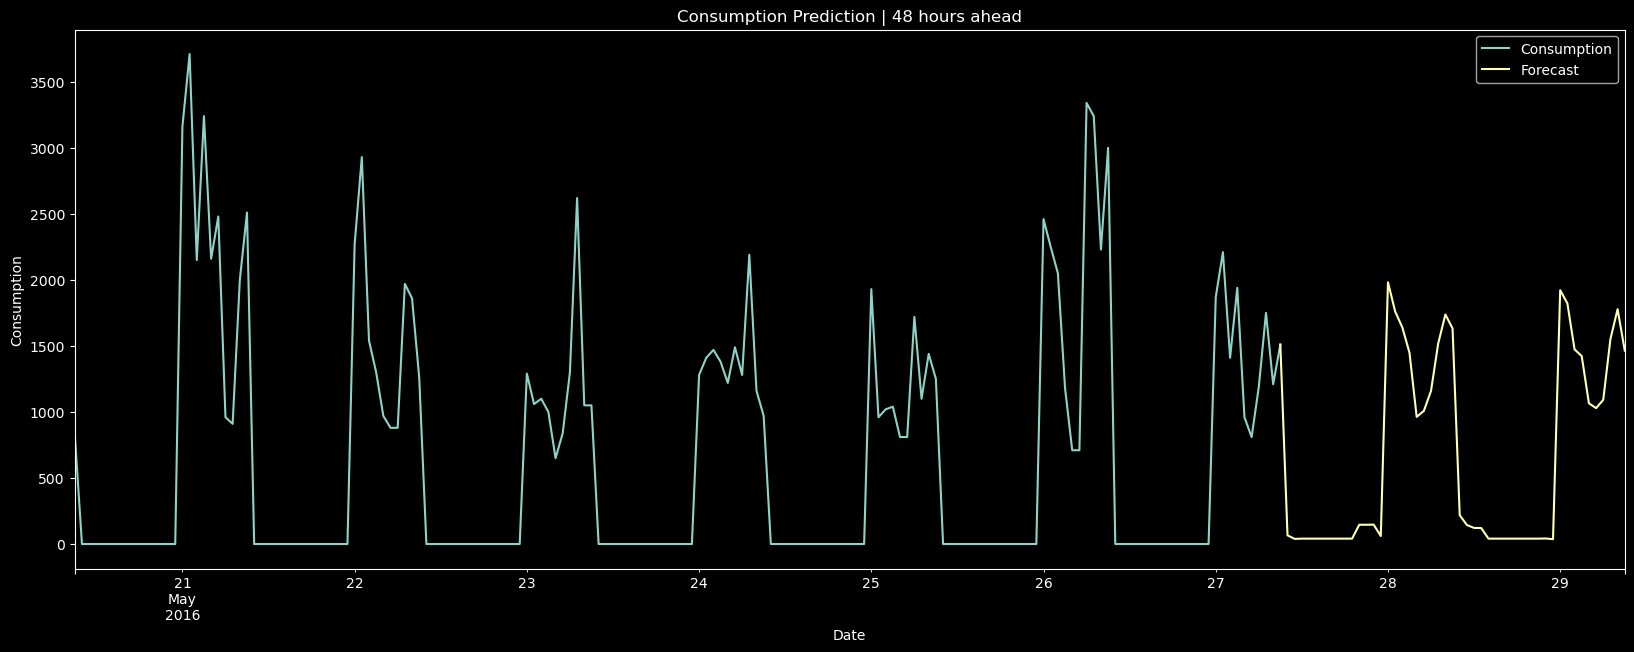

In [24]:
# Plot
prep_forecast["2016-05-20 09:00:00":"2016-05-27 09:00:00"]['Appliances'].plot(label='Consumption',figsize=(20,7))
prep_forecast["2016-05-27 09:00:00":]['Appliances'].plot(label= 'Forecast', figsize=(20,7))
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Consumption Prediction | 48 hours ahead')
plt.legend()
plt.show()

In [25]:
prep_forecast.tail(50)

,Appliances,DayOfWeek,Month,Quarter,Year,DayOfYear,WeekOfYear,ConsumptionLag_1,ConsumptionLag_2,ConsumptionLag_3,...,ConsumptionLag_15,ConsumptionLag_16,ConsumptionLag_17,ConsumptionLag_18,ConsumptionLag_19,ConsumptionLag_20,ConsumptionLag_21,ConsumptionLag_22,ConsumptionLag_23,Hour
2016-05-27 08:00:00,1210,4,5,2,2016,148,21,1750.0,1190.0,810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,8
2016-05-27 09:00:00,1510,4,5,2,2016,148,21,1210.0,1750.0,1190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2016-05-27 10:00:00,66,4,5,2,2016,148,21,1510.0,1210.0,1750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
2016-05-27 11:00:00,39,4,5,2,2016,148,21,66.0,1510.0,1210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2016-05-27 12:00:00,41,4,5,2,2016,148,21,39.0,66.0,1510.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
2016-05-27 13:00:00,41,4,5,2,2016,148,21,41.0,39.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2016-05-27 14:00:00,41,4,5,2,2016,148,21,41.0,41.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2016-05-27 15:00:00,41,4,5,2,2016,148,21,41.0,41.0,41.0,...,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
2016-05-27 16:00:00,41,4,5,2,2016,148,21,41.0,41.0,41.0,...,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
2016-05-27 17:00:00,41,4,5,2,2016,148,21,41.0,41.0,41.0,...,1410.0,2210.0,1870.0,0.0,0.0,0.0,0.0,0.0,0.0,17
